#### Importing The Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

#### Root data directory path

In [2]:
data_dir = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/covid/'

#### Total number of classes

In [3]:
class_names = os.listdir(data_dir)
num_classes = len(class_names)
num_classes

2

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T, datasets

#### Checking CUDA availability

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


#### Transfroming the data

In [6]:
data_transform = T.Compose([
    T.Resize((224, 224)), # Resize the image to 224x224
    T.RandomRotation(degrees=(-20,+20)), # Randomly rotate the image by -20 to +20 degrees
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet mean and std
])

In [7]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)
print("Total count:", total_count)

Total count: 324


In [8]:
data.classes

['COVID', 'NORMAL']

#### Splitting the data

In [9]:
train_count = int(0.6 * total_count) # 60% of the total count
valid_count = int(0.3 * total_count) # 30% of the total count
test_count = total_count - train_count - valid_count # 10% of the total count
train_data, valid_data, test_data = torch.utils.data.random_split(data, [train_count, valid_count, test_count])

In [10]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 324
    Root location: /home/z4hid/gitpublicz4hid/x-ray-vision/notebook/covid/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
len(train_data.indices)

194

In [12]:
len(valid_data.indices)

97

In [13]:
len(test_data.indices)

33

#### defining helper functions

In [14]:
def show_image(image, label, get_denormalize=True):
    
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    if get_denormalize == True:
        image = image * std + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(label)
    
    else:
        plt.imshow(image)
        plt.title(label)
        

def show_grid(image, title=None):
    
    image = image.pretuple(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        

def accuracy(y_pred, y_ture):
    y_pred = F.softmax(y_pred, dim=1)
    top_p,top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_ture.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

       

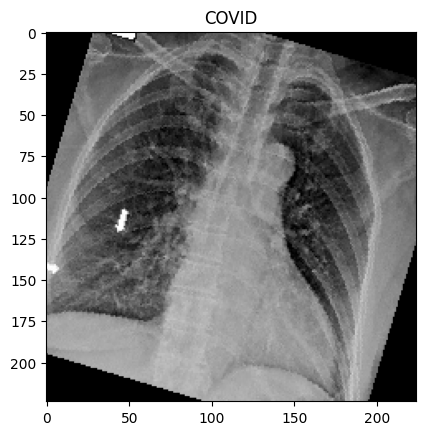

In [15]:
img, label = train_data[0]
show_image(img, class_names[label])

#### data Loaders

In [16]:
traindataloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in train dataloader:", len(traindataloader))
print("No. of Total Examples: ", len(traindataloader.dataset))

validationdataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
print("No. of batches in validation dataloader:", len(validationdataloader))
print("No. of Total Examples: ", len(validationdataloader.dataset))

testdataloader = DataLoader(test_data, batch_size=32, shuffle=False) # Shuffle is set to False
print("No. of batches in test dataloader:", len(testdataloader))
print("No. of Total Examples: ", len(testdataloader.dataset))


No. of batches in train dataloader: 7
No. of Total Examples:  194
No. of batches in validation dataloader: 4
No. of Total Examples:  97
No. of batches in test dataloader: 2
No. of Total Examples:  33


#### Model

In [17]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

In [20]:
model = models.resnet34(weights="ResNet34_Weights.DEFAULT")

In [21]:
model.fc = nn.Linear(model.fc.in_features, 1)  # Change the last layer for binary classification

model = model.to(device)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [22]:
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

def train(model, criterion, optimizer, train_dataloader, val_dataloader, device):
    # Initialize variables to store total loss and predictions
    total_train_loss = 0
    total_val_loss = 0
    train_preds = []
    train_labels = []
    val_preds = []
    val_labels = []
    
    # Set model to training mode
    model.train()
    with tqdm(train_dataloader, unit="batch", leave=False) as pbar:
        pbar.set_description(f"Training")
        for images, labels in pbar:
            # Move data to the specified device
            images = images.to(device, non_blocking=True)
            labels = labels.float().to(device, non_blocking=True)
            
            # Forward pass
            output = model(images).view(-1)  # Ensure output is flattened
            
            # Compute loss
            loss = criterion(output, labels)
            total_train_loss += loss.item()
            
            # Store predictions and labels
            train_preds.extend((output > 0).float().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        with tqdm(val_dataloader, unit="batch", leave=False) as pbar:
            pbar.set_description(f"Validation")
            for images, labels in pbar:
                # Move data to the specified device
                images = images.to(device, non_blocking=True)
                labels = labels.float().to(device, non_blocking=True)
                
                # Forward pass
                output = model(images).view(-1)  # Ensure output is flattened
                
                # Compute loss
                loss = criterion(output, labels)
                total_val_loss += loss.item()
                
                # Store predictions and labels
                val_preds.extend((output > 0).float().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
    
    # Calculate average loss and metrics
    train_loss = total_train_loss / len(train_dataloader)
    val_loss = total_val_loss / len(val_dataloader)
    
    train_acc = (torch.tensor(train_preds) == torch.tensor(train_labels)).float().mean().item()
    val_acc = (torch.tensor(val_preds) == torch.tensor(val_labels)).float().mean().item()
    
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

    return train_loss, train_acc, val_loss, val_acc, val_precision, val_recall, val_f1

# Example usage:
# model = YourModel()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     train_loss, train_acc, val_loss, val_acc, val_precision, val_recall, val_f1 = train(
#         model, criterion, optimizer, train_dataloader, val_dataloader, device
#     )
#     print("-" * 40)

In [23]:
# def train(model, criterion, optimizer, train_dataloader, val_dataloader, device):
#     # Initialize variables to store total loss and correct predictions
#     total_train_loss = 0
#     total_val_loss = 0
#     train_correct = 0
#     val_correct = 0
    
#     # Set model to training mode
#     model.train()
#     with tqdm(train_dataloader, unit="batch", leave=False) as pbar:
#         pbar.set_description(f"Training")
#         for images, idxs in pbar:
#             # Move data to the specified device
#             images = images.to(device, non_blocking=True)
#             idxs = idxs.to(device, non_blocking=True)
            
#             # Forward pass
#             output = model(images)
            
#             # Compute loss
#             loss = criterion(output, idxs)
#             total_train_loss += loss.item()
            
#             # Compute accuracy
#             _, predicted = torch.max(output, 1)
#             train_correct += (predicted == idxs).sum().item()
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
    
#     # Set model to evaluation mode
#     model.eval()
#     with torch.no_grad():  # Disable gradient calculation for validation
#         with tqdm(val_dataloader, unit="batch", leave=False) as pbar:
#             pbar.set_description(f"Validation")
#             for images, idxs in pbar:
#                 # Move data to the specified device
#                 images = images.to(device, non_blocking=True)
#                 idxs = idxs.to(device, non_blocking=True)
                
#                 # Forward pass
#                 output = model(images)
                
#                 # Compute loss
#                 loss = criterion(output, idxs)
#                 total_val_loss += loss.item()
                
#                 # Compute accuracy
#                 _, predicted = torch.max(output, 1)
#                 val_correct += (predicted == idxs).sum().item()
    
#     # Calculate average loss and accuracy
#     train_loss = total_train_loss / len(train_dataloader)
#     val_loss = total_val_loss / len(val_dataloader)
#     train_acc = train_correct / len(train_dataloader.dataset)
#     val_acc = val_correct / len(val_dataloader.dataset)
    
#     # Print results
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

#     return train_loss, train_acc, val_loss, val_acc

In [24]:
%%time
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc, val_loss, val_acc, val_precision, val_recall, val_f1 = train(
        model, criterion, optimizer, traindataloader, validationdataloader, device
    )
    print("-" * 40)

Epoch 1/10


Train Loss: 0.4204, Train Accuracy: 0.7887
Val Loss: 0.4833, Val Accuracy: 0.6907
Val Precision: 0.5915, Val Recall: 0.9767, Val F1: 0.7368
----------------------------------------
Epoch 2/10


Train Loss: 0.2689, Train Accuracy: 0.9175
Val Loss: 0.3396, Val Accuracy: 0.7732
Val Precision: 0.6780, Val Recall: 0.9302, Val F1: 0.7843
----------------------------------------
Epoch 3/10


Train Loss: 0.0968, Train Accuracy: 0.9691
Val Loss: 0.2077, Val Accuracy: 0.9072
Val Precision: 0.8864, Val Recall: 0.9070, Val F1: 0.8966
----------------------------------------
Epoch 4/10


Train Loss: 0.0635, Train Accuracy: 0.9742
Val Loss: 0.1532, Val Accuracy: 0.9278
Val Precision: 0.9091, Val Recall: 0.9302, Val F1: 0.9195
----------------------------------------
Epoch 5/10


Train Loss: 0.2366, Train Accuracy: 0.9742
Val Loss: 0.2243, Val Accuracy: 0.9175
Val Precision: 0.9268, Val Recall: 0.8837, Val F1: 0.9048
----------------------------------------
Epoch 6/10


Train Loss: 0.4395, Train Accuracy: 0.9639
Val Loss: 0.1943, Val Accuracy: 0.8866
Val Precision: 0.8333, Val Recall: 0.9302, Val F1: 0.8791
----------------------------------------
Epoch 7/10


Train Loss: 0.1506, Train Accuracy: 0.9691
Val Loss: 0.2320, Val Accuracy: 0.8866
Val Precision: 0.9706, Val Recall: 0.7674, Val F1: 0.8571
----------------------------------------
Epoch 8/10


Train Loss: 0.1366, Train Accuracy: 0.9433
Val Loss: 0.2227, Val Accuracy: 0.8454
Val Precision: 0.9118, Val Recall: 0.7209, Val F1: 0.8052
----------------------------------------
Epoch 9/10


Train Loss: 0.2321, Train Accuracy: 0.9691
Val Loss: 0.1371, Val Accuracy: 0.9072
Val Precision: 0.9250, Val Recall: 0.8605, Val F1: 0.8916
----------------------------------------
Epoch 10/10


Train Loss: 0.0389, Train Accuracy: 0.9948
Val Loss: 0.2428, Val Accuracy: 0.9381
Val Precision: 1.0000, Val Recall: 0.8605, Val F1: 0.9250
----------------------------------------
CPU times: user 26.9 s, sys: 613 ms, total: 27.5 s
Wall time: 9.74 s


#### Model Saving

In [23]:
path = "/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/model.pt"
torch.save(model, path)

#### Loading saved model

In [24]:
# Model class must be defined
model = torch.load(path, weights_only=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model Evaluation

In [25]:
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def evaluate(model, criterion, test_dataloader, device):
    total_test_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch", leave=False) as pbar:
            pbar.set_description(f"Testing")
            for images, labels in pbar:
                images = images.to(device, non_blocking=True)
                labels = labels.float().to(device, non_blocking=True)
                
                output = model(images).view(-1)
                loss = criterion(output, labels)
                total_test_loss += loss.item()
                
                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    test_loss = total_test_loss / len(test_dataloader)
    test_acc = accuracy_score(all_labels, all_preds)
    test_precision = precision_score(all_labels, all_preds)
    test_recall = recall_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds)
    test_auc = roc_auc_score(all_labels, all_probs)
    
    # Calculate confusion matrix and ROC curve data
    cm = confusion_matrix(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    
    return {
        "loss": test_loss,
        "accuracy": test_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1_score": test_f1,
        "auc": test_auc,
        "confusion_matrix": cm,
        "roc_curve": (fpr, tpr)
    }

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.show()
    # plt.savefig('confusion_matrix.png')
    plt.close()

def plot_roc_curve(fpr, tpr, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    # plt.savefig('roc_curve.png')
    plt.close()

# Example usage:
# model = YourModel()
# criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# 
# metrics = evaluate(model, criterion, test_dataloader, device)
# plot_confusion_matrix(metrics["confusion_matrix"], ['Negative', 'Positive'])
# plot_roc_curve(metrics["roc_curve"][0], metrics["roc_curve"][1], metrics["auc"])


In [26]:
metrics = evaluate(model, criterion, testdataloader, device)

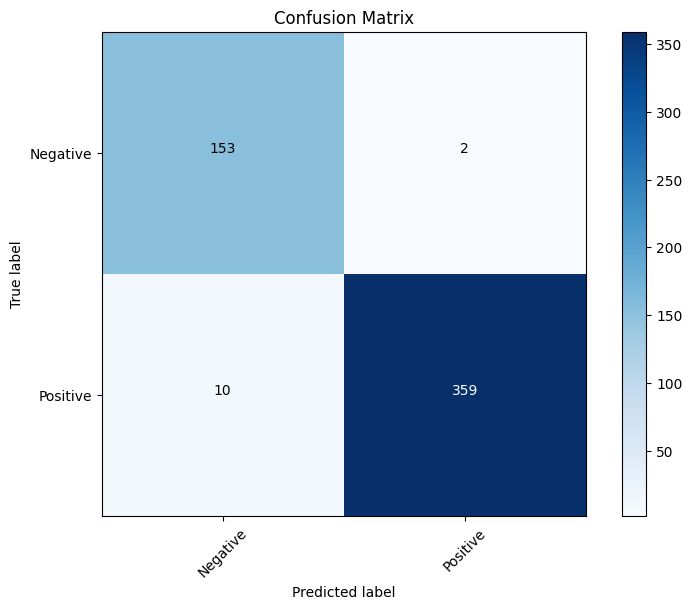

In [27]:
plot_confusion_matrix(metrics["confusion_matrix"], ['Negative', 'Positive'])

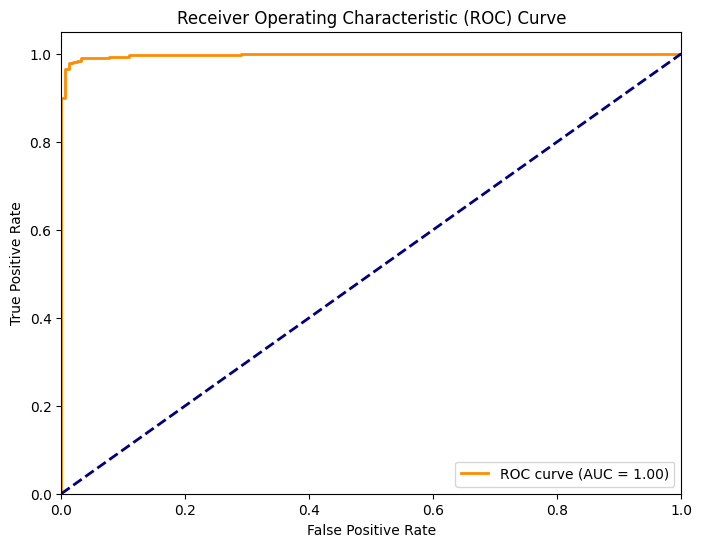

In [28]:
plot_roc_curve(metrics["roc_curve"][0], metrics["roc_curve"][1], metrics["auc"])

#### Prediction

In [29]:
label_name = data.classes
label_name

['NORMAL', 'PNEUMONIA']

In [30]:
from PIL import Image
from torchvision import models, transforms

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the image
# image_path = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/PNEUMONIA/BACTERIA-7422-0001.jpeg'
image_path = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/NORMAL/NORMAL-28501-0001.jpeg'
image = Image.open(image_path)

# Define preprocessing steps
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Grayscale(3),  # Convert to 3 channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])
# # Preprocess the image
# image_tensor = preprocess(image).to(device)

# # Make the prediction
# with torch.no_grad():
#     logits = model(image_tensor)
#     probs = torch.softmax(logits, dim=1)
#     pred_label = torch.argmax(probs, dim=1)

# # Print the prediction
# print(f"Predicted: {pred_label.item()}")

# # Print the predicted label
# print("Predicted Label:", label_name[pred_label.item()])

In [32]:
# Function to predict
def predict_image(image_path, model, preprocess, device):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.sigmoid(output)
        predicted = (probability > 0.5).float()
    
    return predicted.item(), probability.item()

# Load and predict the image
image_path = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/PNEUMONIA/BACTERIA-7422-0001.jpeg'
# image_path = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/NORMAL/NORMAL-28501-0001.jpeg'
predicted_class, probability = predict_image(image_path, model, preprocess, device)

# Print the prediction
if predicted_class == 1:
    print(f"Predicted: PNEUMONIA (probability: {probability:.4f})")
else:
    print(f"Predicted: NORMAL (probability: {1-probability:.4f})")

# You can also add a threshold for more nuanced classification if needed
threshold = 0.5
if probability > threshold:
    print(f"Diagnosis: PNEUMONIA (confidence: {probability:.4f})")
else:
    print(f"Diagnosis: NORMAL (confidence: {1-probability:.4f})")

Predicted: PNEUMONIA (probability: 0.9998)
Diagnosis: PNEUMONIA (confidence: 0.9998)
